In [61]:
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G,color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G,pos=nx.spring_layout(G,seed=42),with_labels=False,node_color=color,cmap="rainbow")
    plt.show()
    
def visualize_embedding(h,color,epoch=None,loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.cpu().detach().numpy()
    color = color.cpu()
    plt.scatter(h[:,0],h[0:,1],s=140,c=color,cmap="rainbow")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch:{epoch},Loss:{loss}')

In [14]:
from torch_geometric.datasets import KarateClub as KC

dataset = KC()
print(dataset)
print(f'number of graph:{len(dataset)}')

KarateClub()
number of graph:1


In [59]:
data = dataset[0]
print(data)
print(data.x)
print(data.edge_index)
print(data.y[data.train_mask])
print(data.train_mask)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33

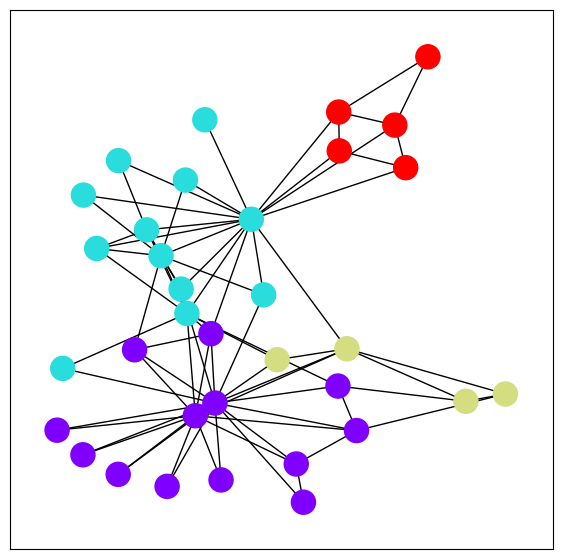

In [62]:
from torch_geometric.utils import to_networkx

G = to_networkx(data,to_undirected = True)
visualize_graph(G,color=data.y)

In [63]:
import torch
from torch.nn import Linear as lin
from torch_geometric.nn import GCNConv as gcn

class GCN(torch.nn.Module):
    def __init__(self,nf,nc):
        super().__init__()
        torch.cuda.manual_seed(1234)
        self.conv1 = gcn(nf,16)
        self.conv2 = gcn(16,9)
        self.conv3 = gcn(9,2)
        self.classifier = lin(2,nc)
        
    def forward(self,x,edge):
        h = self.conv1(x,edge)
        h = h.tanh()
        h = self.conv2(h,edge)
        h = h.tanh()
        h = self.conv3(h,edge)
        h = h.tanh()
        
        out = self.classifier(h)
        
        return out,h



GCN(
  (conv1): GCNConv(34, 16)
  (conv2): GCNConv(16, 9)
  (conv3): GCNConv(9, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


GCN(
  (conv1): GCNConv(34, 16)
  (conv2): GCNConv(16, 9)
  (conv3): GCNConv(9, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)
torch.Size([34, 2])


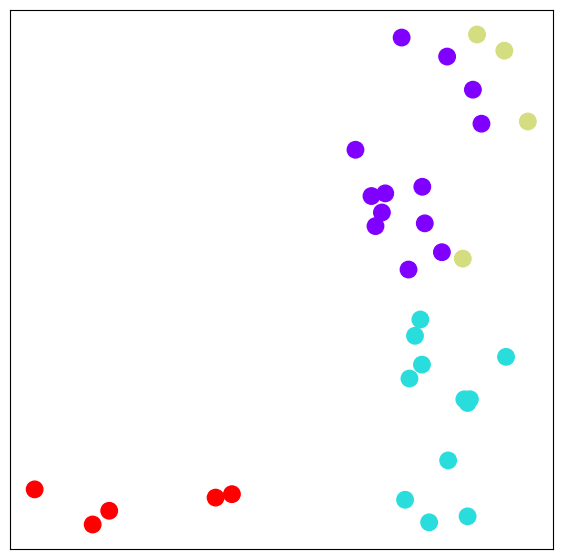

In [70]:
model = GCN(dataset.num_features,dataset.num_classes).cuda()
print(model)
data = data.cuda()
_,h = model(data.x,data.edge_index)
print(h.shape)
visualize_embedding(h,data.y)

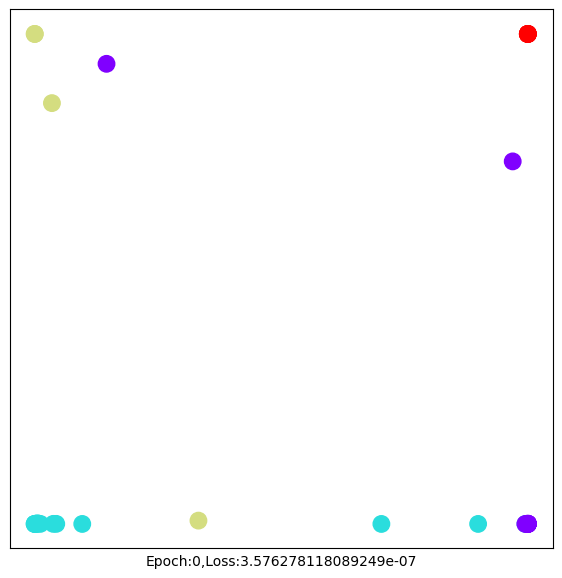

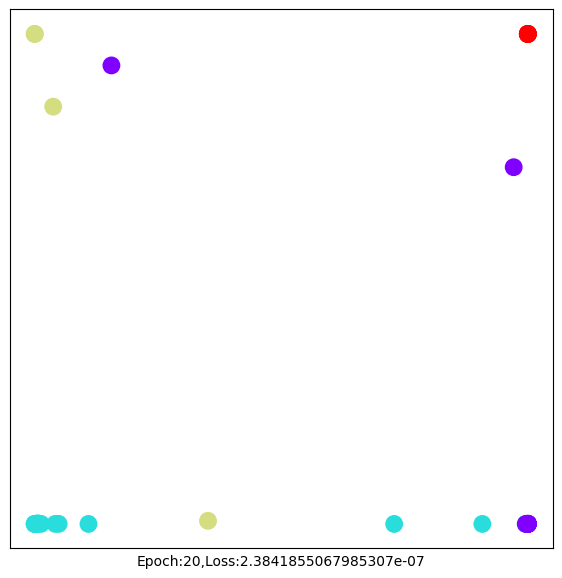

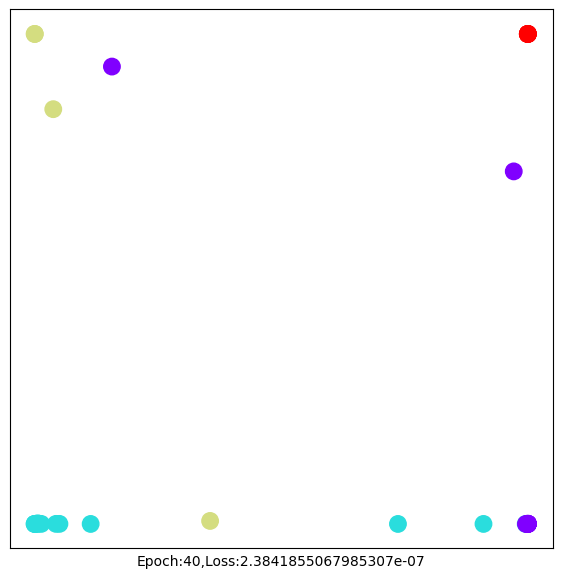

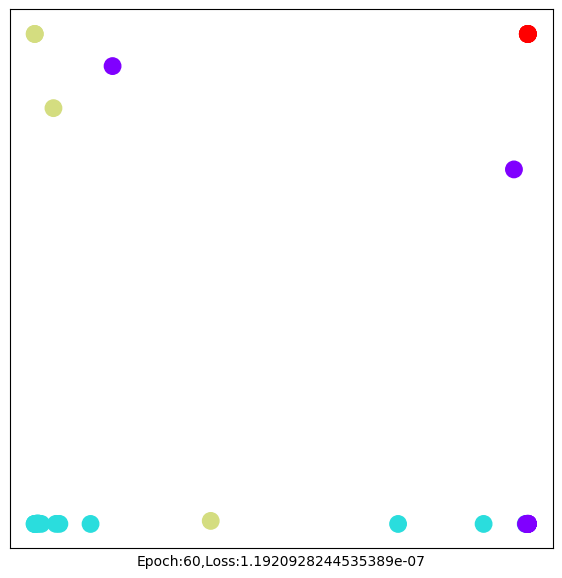

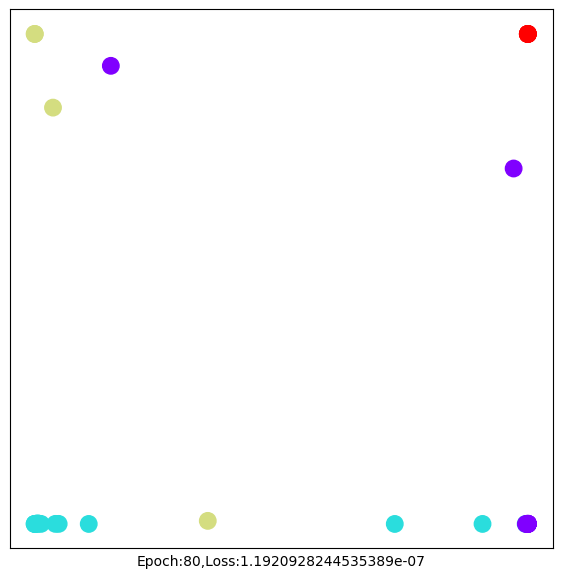

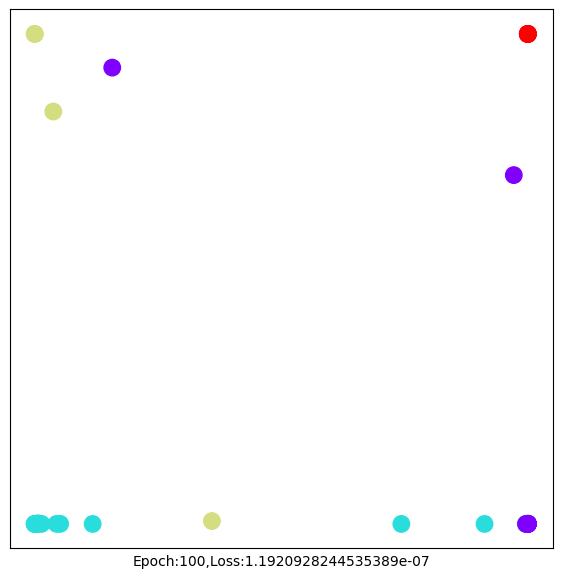

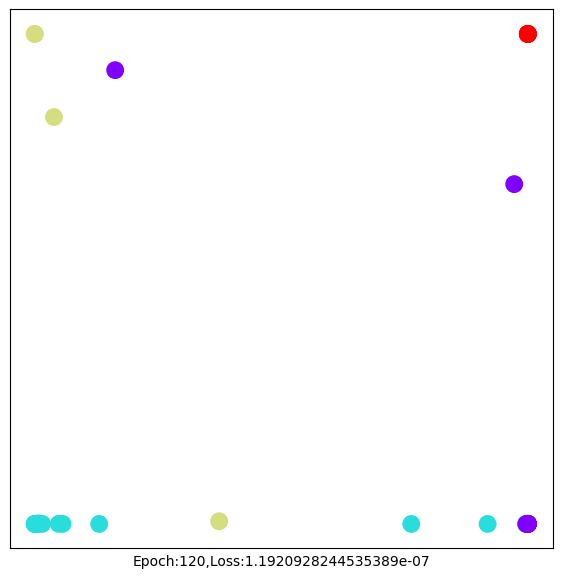

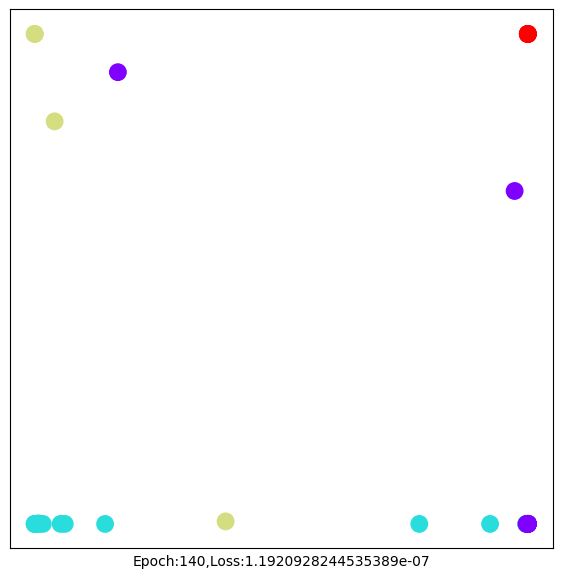

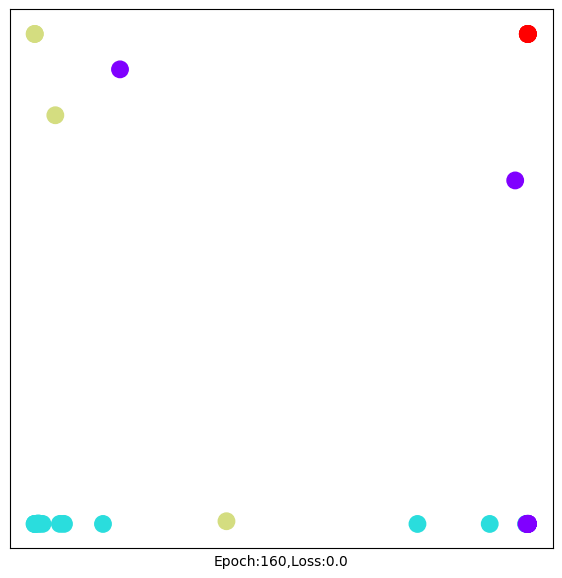

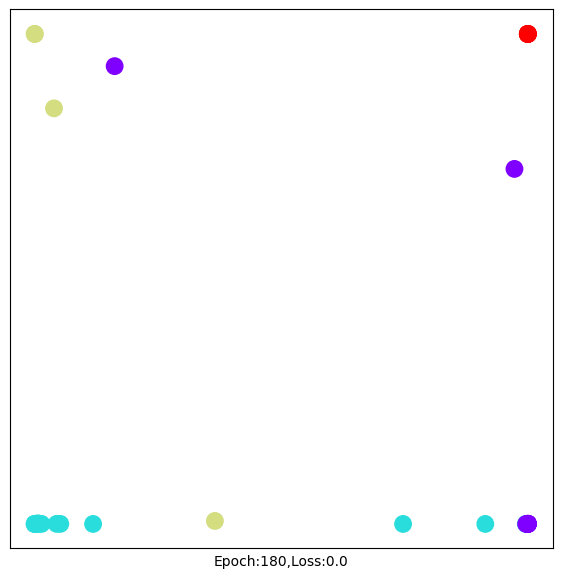

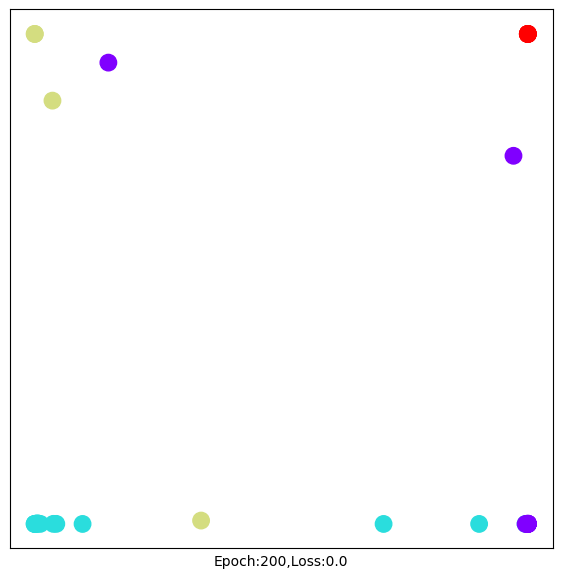

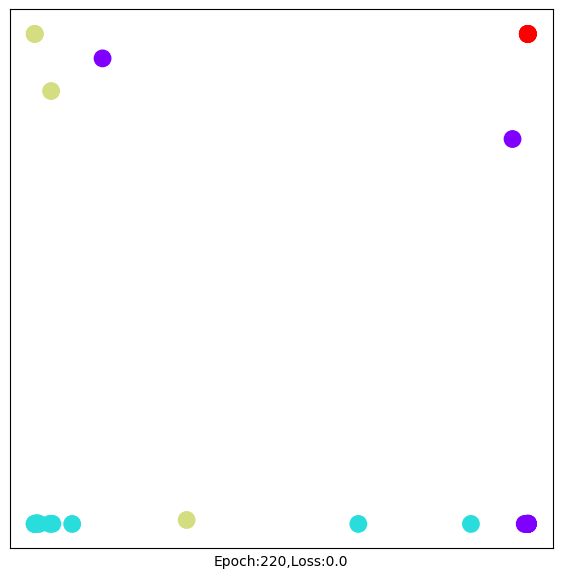

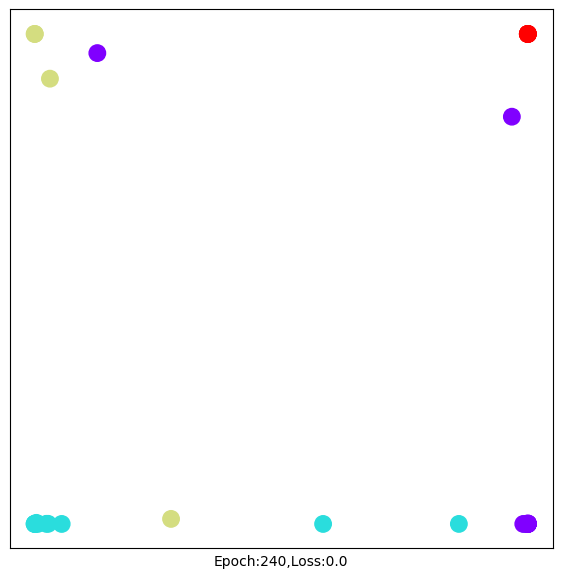

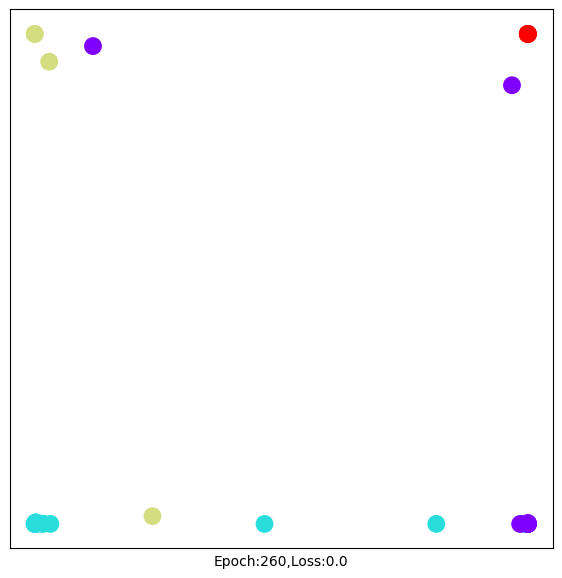

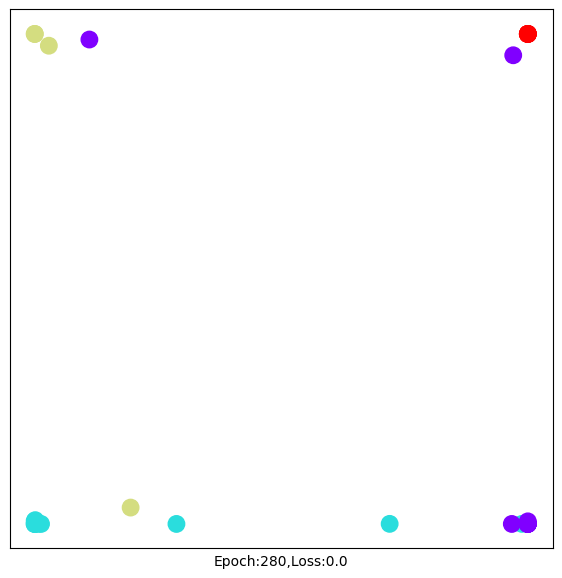

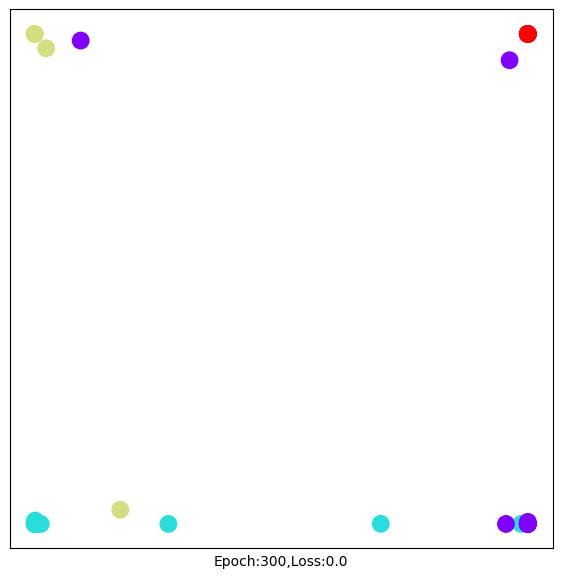

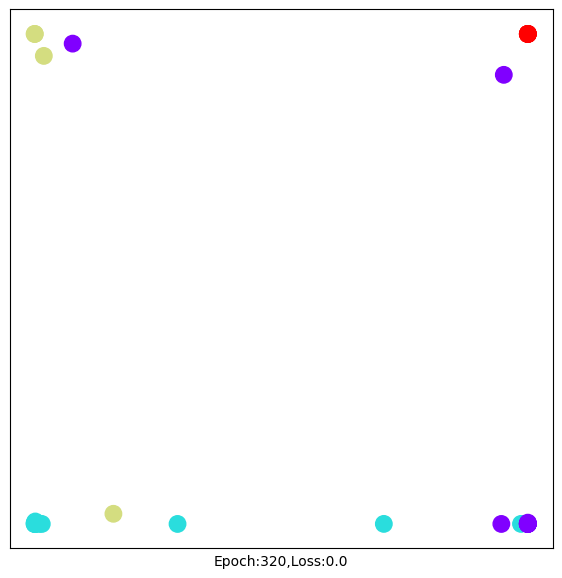

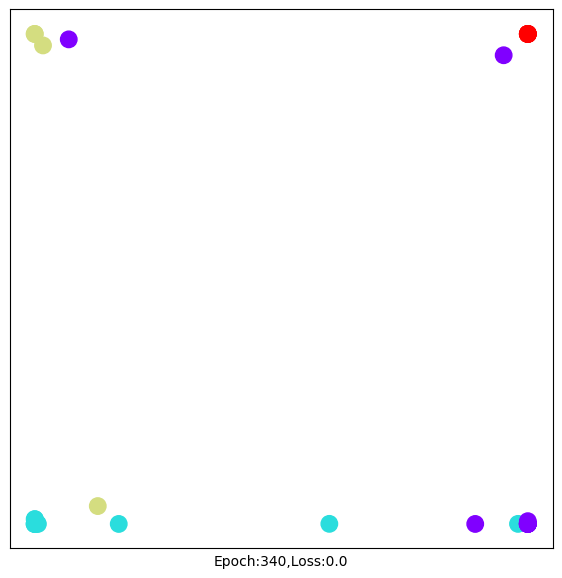

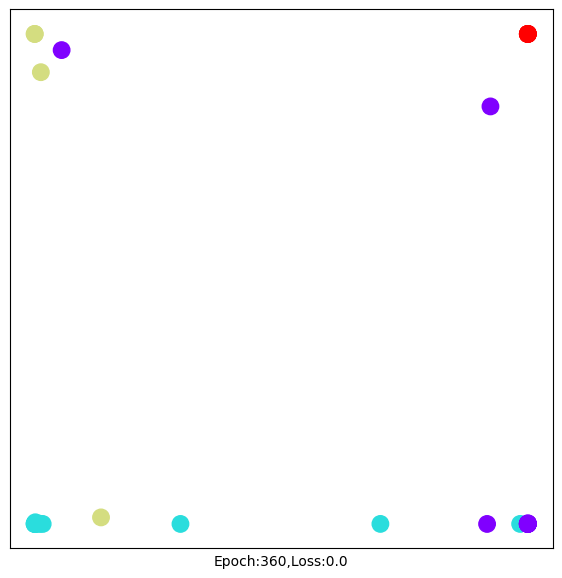

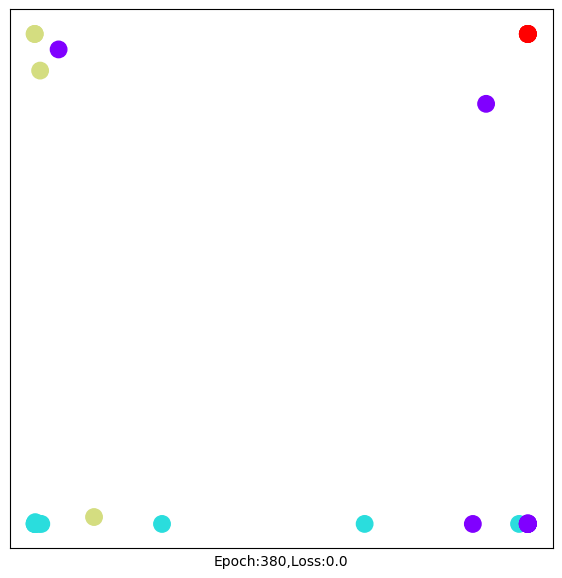

In [82]:
import torch.nn as nn


criter = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(),lr = 1e-2)

def train(data):
    optim.zero_grad()
    out,h = model(data.x,data.edge_index)
    loss = criter(out[data.train_mask],data.y[data.train_mask])
    loss.backward()
    optim.step()
    return loss,h

for epoch in range(400):
    loss,h = train(data)
    if epoch %20 ==0 :
        visualize_embedding(h,data.y,epoch,loss)